In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RESPONSE_VARS = ['Limonene']

INPUT_VARS = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU']

DBTL_A = ['2X-Mh', 'B-Lm', '2X-Ll', 'A-Mm', 'B-Ll', 'A-Mh', '2X-Lm',
       'A-Hl', '2X-Hh', 'B-Ml', 'B-Mm', '2X-Lh', 'B-Mh', '2X-Hl', 'B-Hl',
       '2X-Ml', 'B-Hm', 'B-Lh', 'B-Hh', 'A-Ll', 'A-Hm', '2X-Mm', 'A-Hh',
       'A-Ml', 'A-Lm',  'A-Lh', '2X-Hm']

DBTL_B = ['BL-Mm', 'BL-Mh', 'BL-Ml']

## Read and transform data

In [2]:
def read_data(path: str) -> pd.DataFrame:
    ''' Read data from csv file '''
    df = pd.read_csv(path, index_col=0)
    df = df[['Line Name', 'Type', '24.0']] # Keep only columns EDD style
    df = df.rename(columns={'24.0': 'value'}) # Rename 24.0 to value
    return df

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    ''' Get data to the right format for analysis '''
    new_columns = df['Type'].unique()
    data = pd.DataFrame()
    data.index = df['Line Name'].unique()
    # add new columns to data
    for col in new_columns:
        data[col] = 0.0
    # fill in data
    for l in data.index:
        for c in new_columns:
            value = df[(df['Line Name'] == l) & (df['Type'] == c)]['value'].values
            data.loc[l, c] = value
    # drop OD column
    data.drop('Optical Density', axis=1, inplace=True)
    return data

In [3]:
df = read_data('data/limonene_data.csv')
df = transform_data(df)
print(df.shape)
df.head()

(30, 10)


,MVD1_YEAST,Q40322_MENSP,IDI_ECOLI,ATOB_ECOLI,Q8LKJ3_ABIGR,Q9FD87_STAAU,Q9FD86_STAAU,KIME_YEAST,ERG8_YEAST,Limonene
2X-Mh,2.1936,11.20370,3.18130,0.2384,0.29680,0.74880,0.78160,0.4010,0.94130,75.39261
B-Lm,0.9010,3.55060,1.06380,0.3550,0.28700,1.02540,0.89670,0.2006,0.50610,12.75786
BL-Mm,3.1930,11.31405,2.29065,1.2554,1.63235,0.41045,0.25975,1.0486,0.58985,119.81367
2X-Ll,1.9367,3.06770,1.59950,0.0457,0.14230,0.12100,0.09980,0.2709,0.46910,5.98466
A-Mm,1.2638,6.78340,1.74950,1.4896,3.70420,5.13260,3.97700,0.3517,1.18100,9.66957


In [4]:
# DBTL 1st cycle
data_A = df[df.index.isin(DBTL_A)]
# DBTL 2st cycle
data_B = df[df.index.isin(DBTL_B)]
# Reorder columns based on specific order
data_A = data_A[INPUT_VARS + RESPONSE_VARS]
data_B = data_B[INPUT_VARS + RESPONSE_VARS]

# Save data to csv files
data_A.to_csv('data/data_A.csv')
data_B.to_csv('data/data_B.csv')

## Basic statistical analysis on data

#### Describe dataset

In [5]:
df.describe()

,MVD1_YEAST,Q40322_MENSP,IDI_ECOLI,ATOB_ECOLI,Q8LKJ3_ABIGR,Q9FD87_STAAU,Q9FD86_STAAU,KIME_YEAST,ERG8_YEAST,Limonene
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.446219,5.042353,1.628000,0.570995,0.795225,1.450266,1.135938,0.324945,0.603852,36.509000
std,0.782276,3.170370,0.642693,0.549361,1.131095,1.592779,1.263955,0.270165,0.300270,37.367861
min,0.421500,1.233200,0.714300,0.021900,0.060500,0.042900,0.028000,0.098300,0.189900,1.655130
25%,0.876625,2.934350,1.060575,0.135575,0.163525,0.272475,0.183450,0.193325,0.381075,8.409443
50%,1.298455,3.940550,1.581600,0.297560,0.305750,0.657295,0.605800,0.284750,0.605575,19.614635
75%,1.782050,6.485125,2.051150,1.043300,0.573075,2.334900,1.630100,0.353125,0.772300,56.129280
max,4.104950,13.599190,3.181300,1.959830,4.526700,5.132600,3.977000,1.424960,1.390500,127.994940


__Distribution of every column of the 2 cycles__

Estimate the probability distrubtion that best describes every column

MVD1_YEAST : dweibull


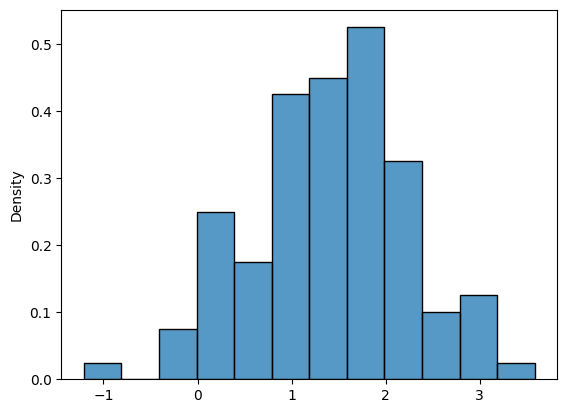

Q40322_MENSP : genextreme


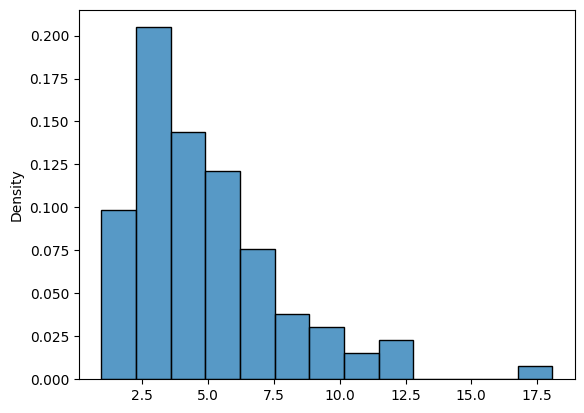

IDI_ECOLI : beta


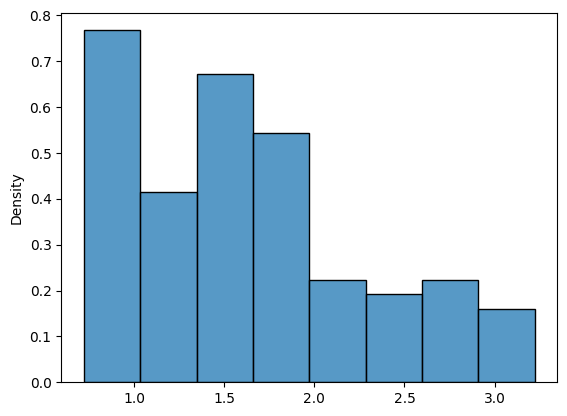

ATOB_ECOLI : lognorm


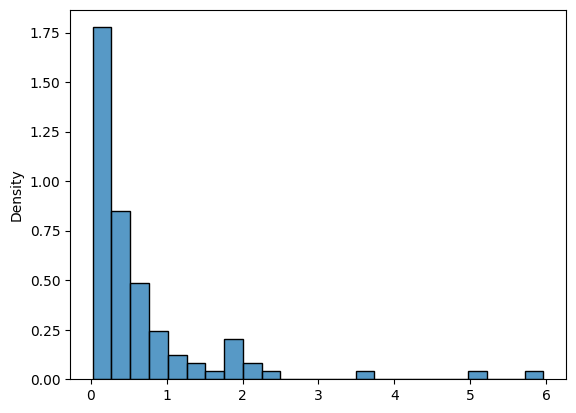

Q8LKJ3_ABIGR : t


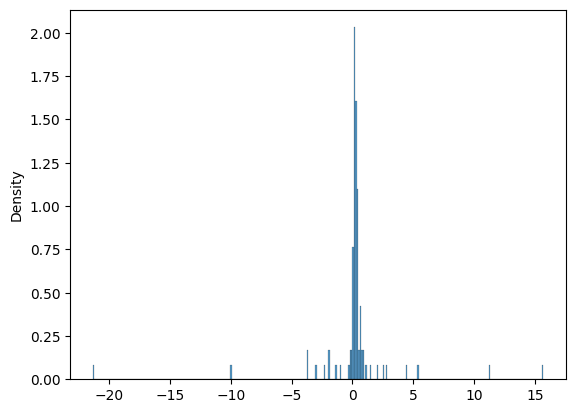

Q9FD87_STAAU : genextreme


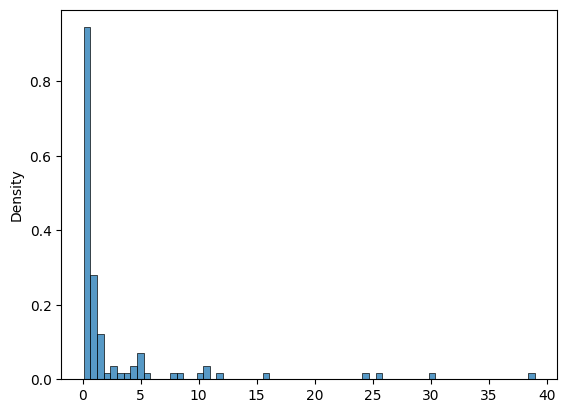

Q9FD86_STAAU : pareto


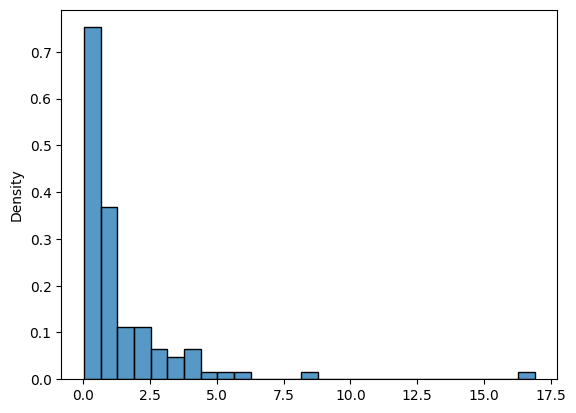

KIME_YEAST : t


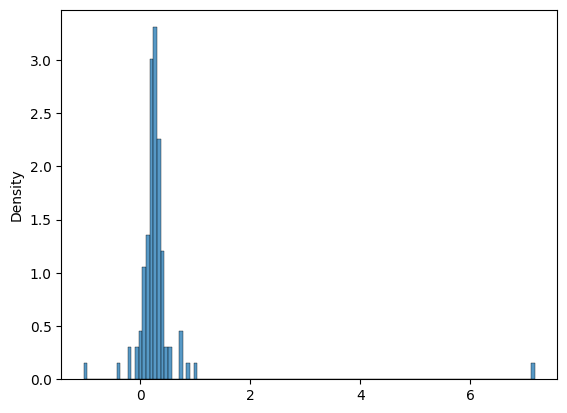

ERG8_YEAST : dweibull


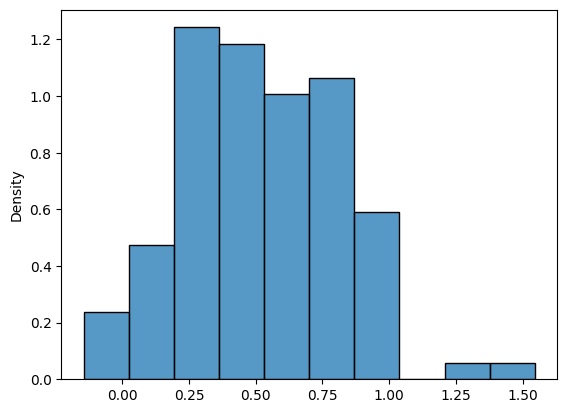

Limonene : lognorm


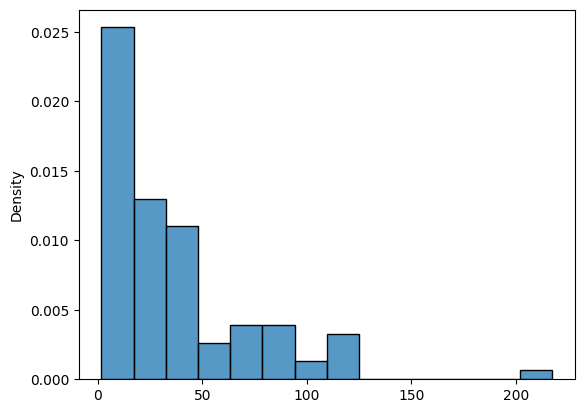

In [6]:
from distfit import distfit

for col in df.columns:
    dist = distfit()
    dist.fit_transform(df[col].values, verbose=0)
    print(f"{col} : {dist.model['name']}")
    X_synthetic = dist.generate(n=100)
    sns.histplot(X_synthetic, stat='density', label='synthetic')
    plt.show()

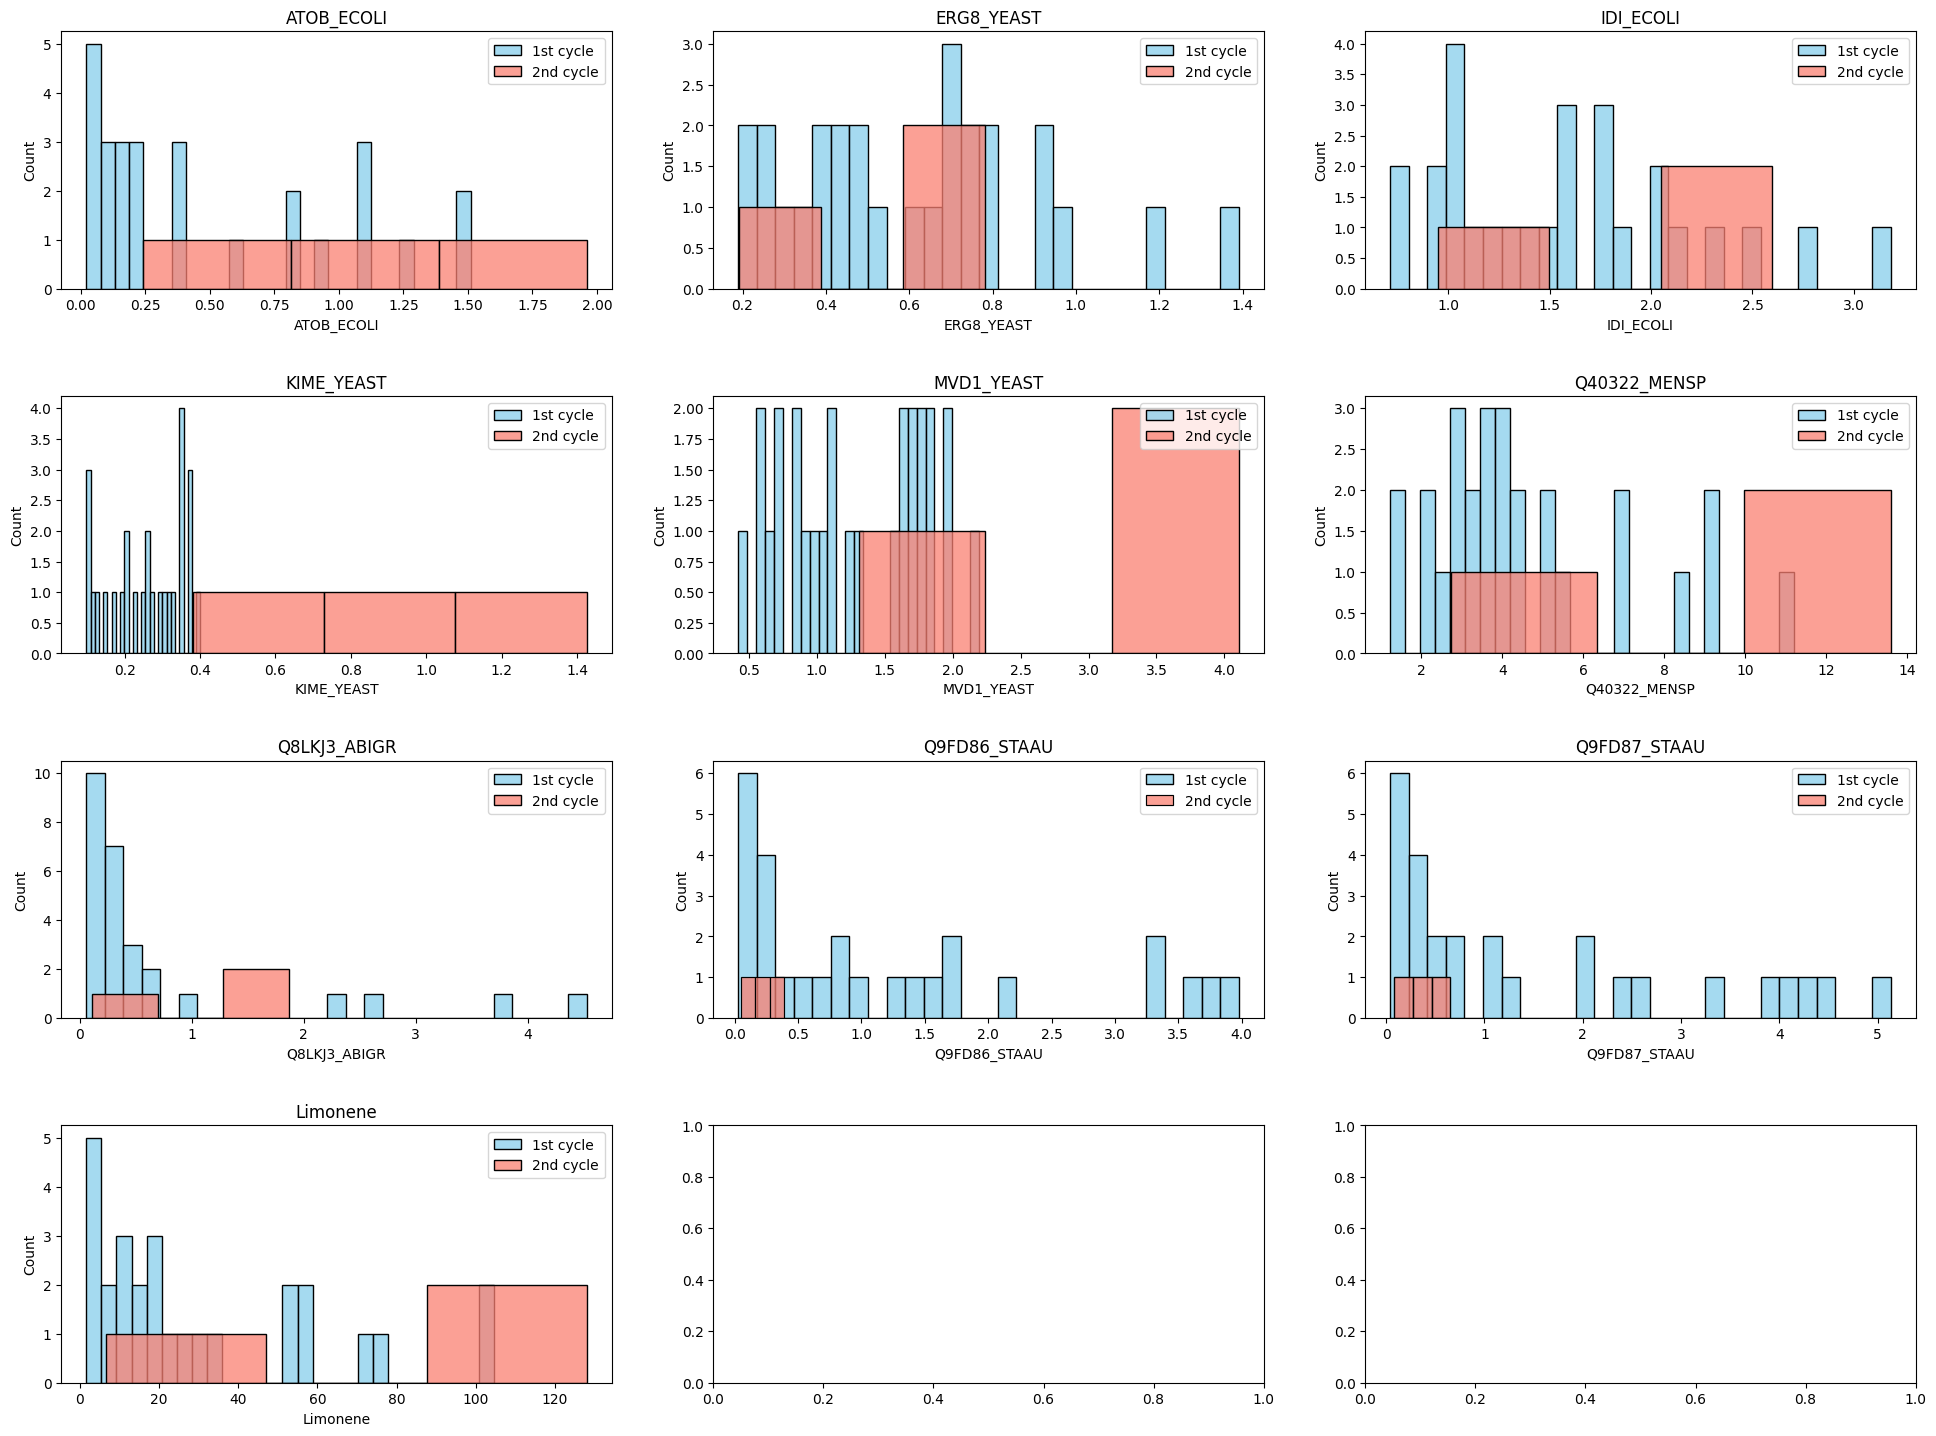

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
for i, col in enumerate(data_A.columns):
    sns.histplot(data_A[col], ax=axes[i//3, i%3], bins=len(data_A), label='1st cycle', color='skyblue')
    sns.histplot(data_B[col], ax=axes[i//3, i%3], bins=len(data_B), label='2nd cycle', color='salmon')
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].legend()
fig.tight_layout(pad=3.0)
plt.show()

__Limonene production__

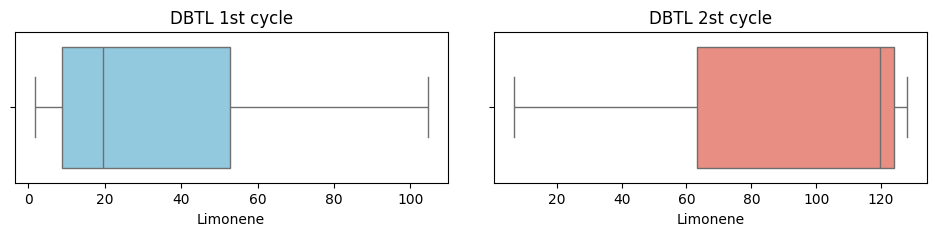

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(data=data_A, x='Limonene', ax=axes[0], color='skyblue')
sns.boxplot(data=data_B, x='Limonene', ax=axes[1], color='salmon')
axes[0].set_title('DBTL 1st cycle')
axes[1].set_title('DBTL 2st cycle')
fig.tight_layout(pad=3.0)
plt.show()

__PCA__

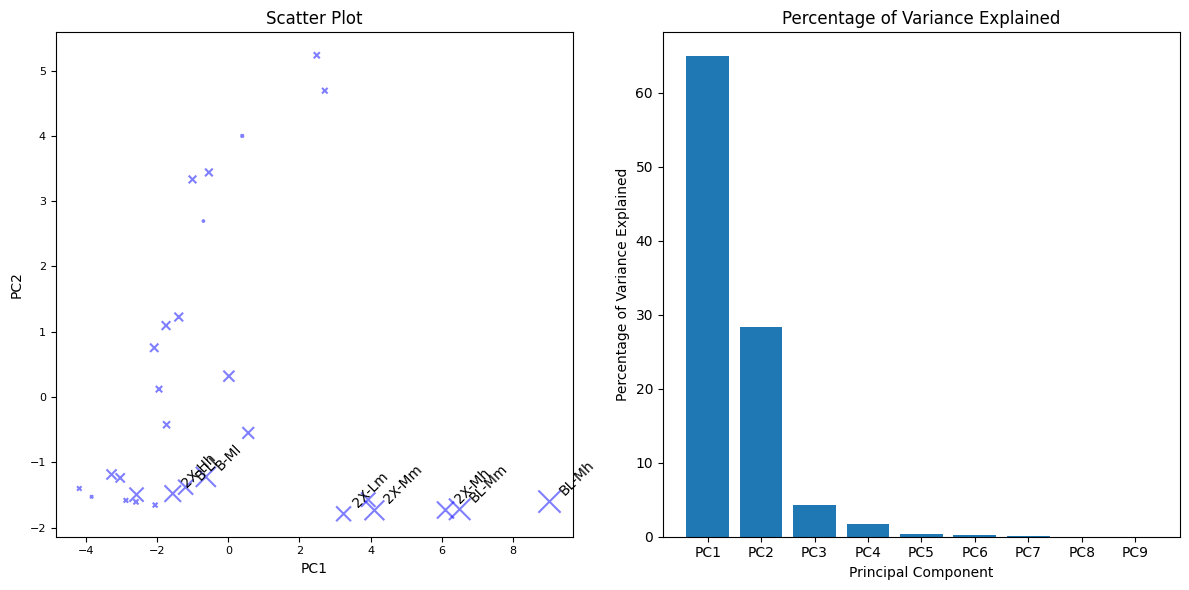

In [5]:
from sklearn.decomposition import PCA

def pca_analysis(df: pd.DataFrame, n_components=9):
    ''' Perform PCA analysis and plot results '''
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(df.drop('Limonene', axis=1)))
    pca_df.index = df.index
    
    # Creating a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Scatter plot on the first subplot (axes[0])
    axes[0].scatter(pca_df[0], pca_df[1], s=df['Limonene']*2, color='blue', marker='x', alpha=0.5)
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].tick_params(labelsize=8)
    for i, txt in enumerate(pca_df.index):
        if df['Limonene'][i] > df['Limonene'].describe()["75%"]:
            axes[0].annotate(txt, (pca_df[0][i], pca_df[1][i]), xytext=(5, 5), 
                             textcoords='offset points', rotation=45)
    axes[0].set_title('Scatter Plot')

    # Bar plot on the second subplot (axes[1])
    pc_var = pca.explained_variance_ratio_
    pc_var = np.round(pc_var * 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(pc_var)+1)]
    axes[1].bar(x=range(1, len(pc_var)+1), height=pc_var, tick_label=labels)
    axes[1].set_ylabel('Percentage of Variance Explained')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_title('Percentage of Variance Explained')

    plt.tight_layout()
    plt.show()

    return pca_df, pca
    
pca_df, pca = pca_analysis(df)

### EDA

In [128]:
# Split data_A to X & y
X = data_A.drop('Limonene', axis=1)
y = data_A['Limonene'].copy()

In [129]:
import optuna 
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-1, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e3)
    
    svr = SVR(C=C, gamma=gamma, kernel=kernel, epsilon=epsilon)
    scores = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_absolute_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_svr = SVR(**best_params)

[I 2023-12-06 13:46:34,621] A new study created in memory with name: no-name-328ed4fe-d353-4683-a591-33b006b94712
[I 2023-12-06 13:46:34,642] Trial 0 finished with value: 14.5411795234892 and parameters: {'C': 16.185302034791636, 'gamma': 0.010806379670485287, 'kernel': 'linear', 'epsilon': 3.5457291349347435}. Best is trial 0 with value: 14.5411795234892.
[I 2023-12-06 13:46:34,662] Trial 1 finished with value: 33.674306266666676 and parameters: {'C': 206.36253151837914, 'gamma': 0.6176871662006693, 'kernel': 'rbf', 'epsilon': 71.29705760310773}. Best is trial 0 with value: 14.5411795234892.
[I 2023-12-06 13:46:34,686] Trial 2 finished with value: 14.573181212626428 and parameters: {'C': 18.698280795440933, 'gamma': 72.4388665882982, 'kernel': 'linear', 'epsilon': 0.2582869318586435}. Best is trial 0 with value: 14.5411795234892.
[I 2023-12-06 13:46:34,709] Trial 3 finished with value: 15.796187114906393 and parameters: {'C': 46.47314176593596, 'gamma': 32.9908488573368, 'kernel': 'li

In [137]:
score = cross_val_score(best_svr, X, y, cv=5, scoring='neg_mean_absolute_error')
best_svr.fit(X, y)
print(f'AVG(MAE) = {np.abs(score.mean())}')

AVG(MAE) = 13.481255712422017


## SHAP

In [138]:
import shap

explainer = shap.KernelExplainer(best_svr.predict, X)
shap_values = explainer.shap_values(X)

  0%|          | 0/27 [00:00<?, ?it/s]

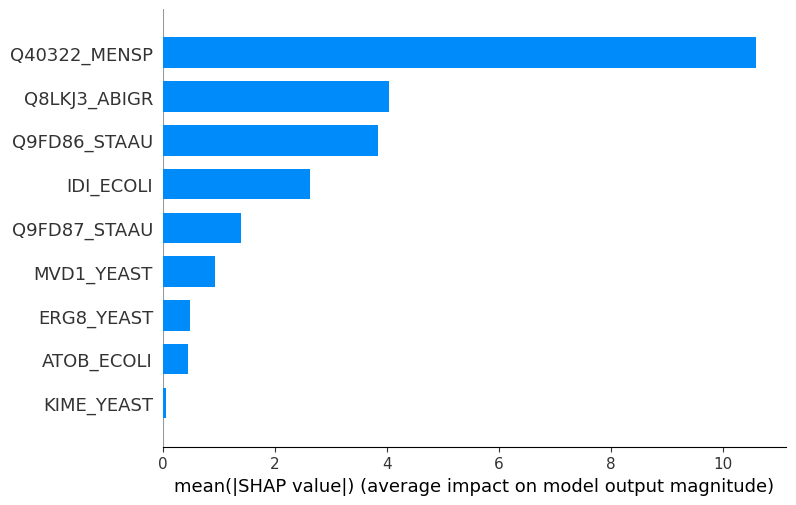

In [140]:
# Plot feature importances based on shap values
shap.summary_plot(shap_values, X, plot_type='bar')